<a href="https://colab.research.google.com/github/Rig12332113/ML_practice/blob/main/practice3%3ACNN/machine_learning_practice3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Get data and data processing


In [ ]:
!wget -O food11.zip https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0
! unzip food11.zip

- 1.1 Visualize the image

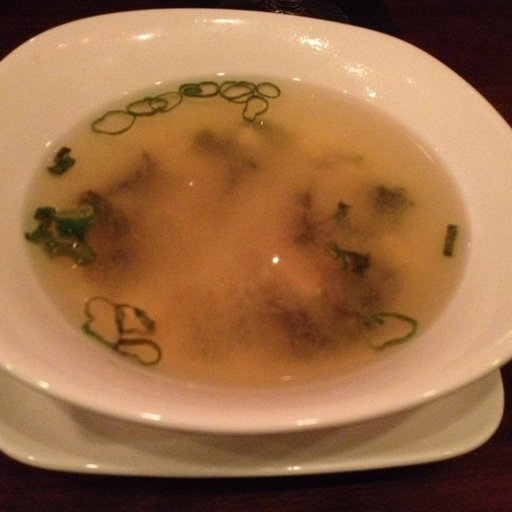

In [ ]:
import random
import os
from PIL import Image
path = '/content/train/'
image_path = path + random.choice(os.listdir(path))
image = Image.open(image_path)
image

# 2. Set random seed


In [ ]:
import torch
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

# 3. Dataset and dataloader


In [ ]:
from torch.utils.data import Dataset, DataLoader
class imagedataset(Dataset):
    def __init__(self, path, transform=None, files = None):
        super(imagedataset, self).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files is not None:
            self.files = files
        self.transform = transform

    def __getitem__(self, index):
        name = self.files[index]
        label = int(name.split("/")[-1].split("_")[0])  # split : chop string into small pieces --> list
                                                         # ref : https://www.freecodecamp.org/chinese/news/how-to-split-a-string-in-python/
        image = Image.open(name)
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.files)


- 3.1 transform (including data augmentation)

In [ ]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor()
])


# 4. model, loss_fn and optimizer

In [ ]:
import torch.nn as nn
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.judge = nn.Sequential(
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(512*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )
    def forward(self, x):
        x = self.stack(x)
        return self.judge(x)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.0003

classifier = Classifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr = LEARNING_RATE, weight_decay=1e-5)

In [ ]:
train_dataset = imagedataset(path = '/content/train/', transform = transform)
test_dataset = imagedataset(path = '/content/valid/', transform = transform)

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

# 5. Training



In [ ]:
import tqdm
best_accuracy = 0
for epoch in range(EPOCHS):
    classifier.train()
    for batchNum, (images, labels) in enumerate(tqdm.tqdm(train_dataloader)):
        # make prediction
        images, labels = images.to(device), labels.to(device)
        logits = classifier(images)
        pred = torch.argmax(logits, dim = 1)

        # calculate loss and accuracy
        loss = loss_fn(logits, labels)
        accuracy = torch.mean((pred == labels).type(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.inference_mode():
        for batchNum, (images, labels) in enumerate(tqdm.tqdm(test_dataloader)):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            pred = torch.argmax(logits, dim = 1)
            test_loss = loss_fn(logits, labels)
            test_accuracy = torch.mean((pred == labels).type(torch.float))

    if (test_accuracy > best_accuracy):
        best_accuracy = test_accuracy
        torch.save(classifier.state_dict(), "best.ckpt")

    print(f"Epoch: {epoch} | Train Loss: {loss} | Train Accuracy: {accuracy} | Test Loss: {test_loss} | Test Accuracy: {test_accuracy}")

100%|██████████| 57/57 [00:15<00:00,  3.56it/s]


Epoch: 0 | Train Loss: 2.122192859649658 | Train Accuracy: 0.125 | Test Loss: 2.1607930660247803 | Test Accuracy: 0.1525423675775528


100%|██████████| 57/57 [00:15<00:00,  3.70it/s]


Epoch: 1 | Train Loss: 2.508655071258545 | Train Accuracy: 0.1875 | Test Loss: 1.7462557554244995 | Test Accuracy: 0.35593220591545105


100%|██████████| 57/57 [00:15<00:00,  3.71it/s]


Epoch: 2 | Train Loss: 1.4960601329803467 | Train Accuracy: 0.5 | Test Loss: 1.810479760169983 | Test Accuracy: 0.2542372941970825


100%|██████████| 57/57 [00:16<00:00,  3.55it/s]


Epoch: 3 | Train Loss: 1.8758183717727661 | Train Accuracy: 0.375 | Test Loss: 1.962172031402588 | Test Accuracy: 0.2881355881690979


100%|██████████| 57/57 [00:15<00:00,  3.57it/s]


Epoch: 4 | Train Loss: 1.5314866304397583 | Train Accuracy: 0.4375 | Test Loss: 2.061805486679077 | Test Accuracy: 0.2711864411830902


100%|██████████| 57/57 [00:16<00:00,  3.50it/s]


Epoch: 5 | Train Loss: 1.605824589729309 | Train Accuracy: 0.5 | Test Loss: 2.603287696838379 | Test Accuracy: 0.033898305147886276


100%|██████████| 57/57 [00:15<00:00,  3.61it/s]


Epoch: 6 | Train Loss: 0.9609559178352356 | Train Accuracy: 0.75 | Test Loss: 1.5179457664489746 | Test Accuracy: 0.4237288236618042


100%|██████████| 57/57 [00:15<00:00,  3.66it/s]


Epoch: 7 | Train Loss: 1.6175012588500977 | Train Accuracy: 0.4375 | Test Loss: 3.024050712585449 | Test Accuracy: 0.08474576473236084


100%|██████████| 57/57 [00:15<00:00,  3.62it/s]


Epoch: 8 | Train Loss: 0.7762823104858398 | Train Accuracy: 0.75 | Test Loss: 1.9091264009475708 | Test Accuracy: 0.33898305892944336


100%|██████████| 57/57 [00:16<00:00,  3.52it/s]

Epoch: 9 | Train Loss: 0.658394455909729 | Train Accuracy: 0.75 | Test Loss: 2.57291841506958 | Test Accuracy: 0.3050847351551056


# 6. Evaluate and show predict

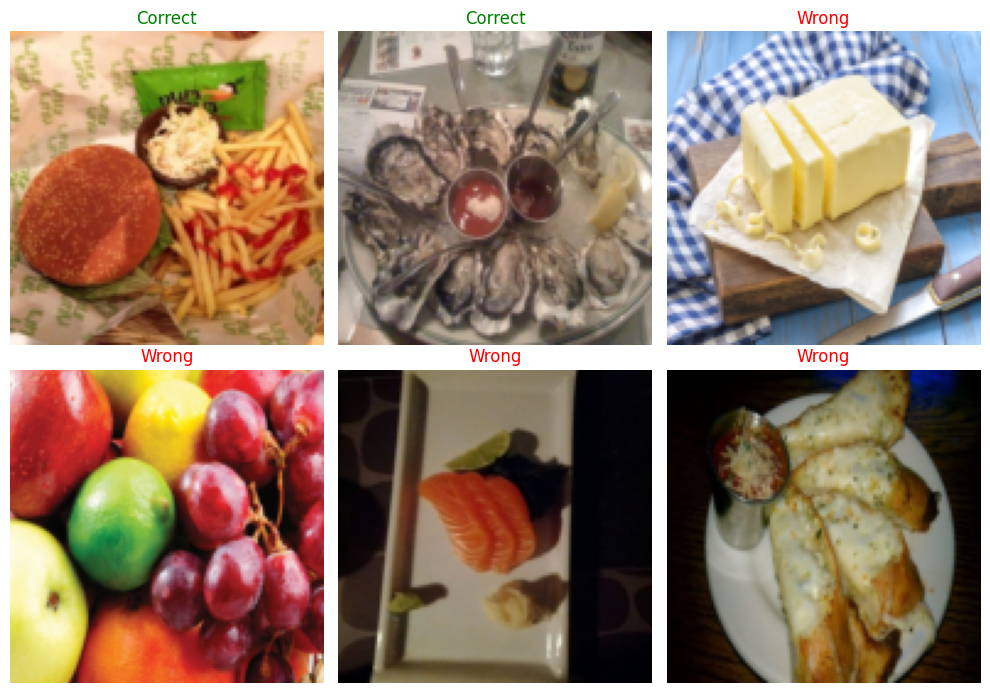

In [ ]:
# 6. Evaluate and show predict
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
nrows = 2
ncols = 3
#random.seed(42)
path = '/content/valid/'
for i in range(6):
    # random select image
    image_path = path + random.choice(os.listdir(path))
    image = Image.open(image_path)
    # make prediction
    label = int(image_path.split("/")[-1].split("_")[0])
    image = transform(image).unsqueeze(dim = 0).to(device)
    logits = classifier(image)
    pred = torch.argmax(logits, dim=1)
    # show image
    image = image.squeeze().permute(1,2,0).cpu()
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(image)


    plt.axis(False)
    if pred == label:
        plt.title("Correct", c='g')
    else:
        plt.title("Wrong",c='r')

plt.tight_layout()
plt.show()

- Could use confusion matrix to show the result

# Reference (sample code):
- https://colab.research.google.com/drive/15A_8ilH-6-T3HOmSFrKbjDinBJl-s-16?pli=1&authuser=2#scrollTo=2_OeWtstVaVO